## Import & Explore

In [248]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as lr

In [90]:
df = pd.read_csv('hotels_mod.csv')

In [91]:
df.shape

(50000, 23)

In [92]:
df.head()

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
0,City_Hotel,217,1,3,2,none,BB,DEU,Offline_TA/TO,TA/TO,...,A,A,0,NaN,0,Transient-Party,80.75,none,NaN,1/9/2016
1,City_Hotel,2,0,1,2,none,BB,PRT,Direct,Direct,...,D,K,0,NaN,0,Transient,170.00,none,3.0,25/8/2017
2,Resort_Hotel,95,2,5,2,none,BB,GBR,Online_TA,TA/TO,...,A,A,2,No_Deposit,0,Transient,8.00,none,2.0,19/11/2016
3,Resort_Hotel,143,2,6,2,none,HB,ROU,Online_TA,TA/TO,...,A,A,0,No_Deposit,0,Transient,81.00,none,NaN,26/4/2016
4,Resort_Hotel,136,1,4,2,none,HB,PRT,Direct,Direct,...,F,F,0,No_Deposit,0,Transient,157.60,none,4.0,28/12/2016


In [94]:
df.columns

Index(['hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'average_daily_rate',
       'required_car_parking_spaces', 'total_of_special_requests',
       'arrival_date'],
      dtype='object')

In [95]:
df.isna().sum()

hotel                                 0
lead_time                             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
meal                                  0
country                             289
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                      10000
days_in_waiting_list                  0
customer_type                         0
average_daily_rate                    0
required_car_parking_spaces           0
total_of_special_requests         14000
arrival_date                          0
dtype: int64

In [96]:
df.duplicated().sum()

4142

In [97]:
df.total_of_special_requests.value_counts()

0.0    17633
1.0    12393
2.0     4803
3.0      989
4.0      166
5.0       16
Name: total_of_special_requests, dtype: int64

In [98]:
df.deposit_type.value_counts()

No_Deposit    39875
Refundable       69
Non_Refund       56
Name: deposit_type, dtype: int64

In [99]:
df.children.value_counts()

none        45962
children     4038
Name: children, dtype: int64

In [103]:
df.required_car_parking_spaces.value_counts()

none       45019
parking     4981
Name: required_car_parking_spaces, dtype: int64

## Data Preparation

In [127]:
def preprocessing(df, obj_list):
    
    df = df.dropna(subset=['country'])
    df = df.drop_duplicates()
    df = df.drop(['arrival_date'], axis=1)
    
    df['total_of_special_requests'] = df['total_of_special_requests'].fillna(0.0)
    df['deposit_type'] = df['deposit_type'].fillna('No_Deposit')
    df['children'] = df['children'].apply(lambda x: 1 if x=='children' else 0)
    df['required_car_parking_spaces'] = df['required_car_parking_spaces'].apply(lambda x: 1 if x=="parking" else 0)
    df['previous_bookings_not_canceled'] = df['previous_bookings_not_canceled'].apply(lambda x: 30 if x>=30 else x)
    
    dummy = pd.get_dummies(df[obj_list])
    df = df.drop(obj_list, axis=1)
    
    df = pd.concat([df, dummy], axis=1)
    
    return df

In [128]:
def standardize(df, int_list):
    
    scaler = StandardScaler()
    df[int_list]  = scaler.fit_transform(df[int_list])
    
    return df

In [129]:
df.dtypes

hotel                              object
lead_time                         float64
stays_in_weekend_nights           float64
stays_in_week_nights              float64
adults                            float64
children                           object
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations            float64
previous_bookings_not_canceled    float64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                   float64
deposit_type                       object
days_in_waiting_list              float64
customer_type                      object
average_daily_rate                float64
required_car_parking_spaces        object
total_of_special_requests         float64
arrival_date                       object
dtype: object

In [130]:
df.days_in_waiting_list.value_counts()

-0.106179    49116
 3.815349      114
 5.776114       47
 2.463098       34
 4.153412       34
             ...  
 5.370438        1
 8.074941        1
 2.395486        1
 1.786973        1
 1.110847        1
Name: days_in_waiting_list, Length: 92, dtype: int64

In [131]:
obj_list = ['hotel','meal','country','market_segment','distribution_channel','reserved_room_type',
                'assigned_room_type', 'deposit_type', 'customer_type']
int_list = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
           'adults', 'previous_cancellations', 'previous_bookings_not_canceled',
           'booking_changes', 'days_in_waiting_list', 'average_daily_rate',
            'total_of_special_requests']

df_clean = preprocessing(df, obj_list)
df_scale = standardize(df_clean, int_list)

In [132]:
df_scale

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1.675977,0.045399,0.253669,0.31395,0,0,-0.060415,-0.117378,-0.404312,-0.08635,...,0,0,0,1,0,0,0,0,0,1
1,-0.847954,-0.954020,-0.767031,0.31395,0,0,-0.060415,-0.117378,-0.404312,-0.08635,...,0,0,1,1,0,0,0,0,1,0
2,0.243793,1.044819,1.274368,0.31395,0,0,-0.060415,-0.117378,2.223761,-0.08635,...,0,0,0,1,0,0,0,0,1,0
3,0.807276,1.044819,1.784718,0.31395,0,0,-0.060415,-0.117378,-0.404312,-0.08635,...,0,0,0,1,0,0,0,0,1,0
4,0.725101,0.045399,0.764019,0.31395,0,0,-0.060415,-0.117378,-0.404312,-0.08635,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.147713,-0.954020,-0.256681,0.31395,1,0,-0.060415,-0.117378,0.909724,-0.08635,...,0,0,0,1,0,0,0,0,1,0
49996,-0.307950,-0.954020,0.764019,0.31395,0,0,-0.060415,-0.117378,2.223761,-0.08635,...,0,0,0,1,0,0,0,0,1,0
49997,0.948146,-0.954020,0.764019,0.31395,0,0,-0.060415,-0.117378,-0.404312,-0.08635,...,0,0,0,1,0,0,0,0,1,0
49998,0.772058,1.044819,1.274368,0.31395,0,0,-0.060415,-0.117378,-0.404312,-0.08635,...,0,0,0,1,0,0,0,0,1,0


## Modeling

In [250]:
X = df_scale.drop(['children'], axis=1)
y = df_scale['children']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=42)
X_train_upsamp, y_train_upsamp = smote.fit_resample(X_train, y_train)

cv = KFold(n_splits=10, random_state=42, shuffle=True)
model = lr()
scores = cross_val_score(model, X_train_upsamp, y_train_upsamp, scoring='f1_micro', cv=cv, n_jobs=-1)
print(scores)

[0.90984222 0.91254696 0.90788881 0.90683696 0.91525169 0.90638618
 0.90458302 0.90773854 0.90291554 0.91042982]


In [251]:
model.fit(X_train_upsamp, y_train_upsamp)

/Users/panja/opt/anaconda3/envs/rnd/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [258]:
#train set result
threshold = 0.5
predictions = model.predict_proba(X_train_upsamp)[:,1]
predictions = (predictions > threshold).astype(int)

print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(y_train_upsamp, predictions)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(y_train_upsamp, predictions)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(y_train_upsamp, predictions)))

Accuracy: 0.9091

Confusion matrix:
[[31751  1523]
 [ 4529 28745]]

F1 score is: 0.9048


In [259]:
#test set result
threshold_up = 0.5
predictions_up = model.predict_proba(X_valid)[:,1]
predictions_up = (predictions_up > threshold_up).astype(int)

print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(y_valid, predictions_up)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(y_valid, predictions_up)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(y_valid, predictions_up)))

Accuracy: 0.9134

Confusion matrix:
[[7923  362]
 [ 427  402]]

F1 score is: 0.5047


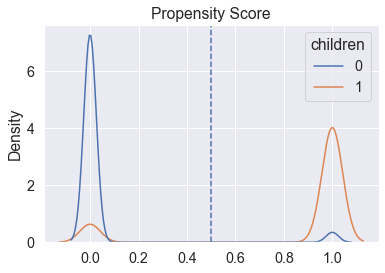

In [262]:
fig, ax = plt.subplots()
sns.kdeplot(x = predictions, hue = y_train_upsamp)
ax.axvline(0.5, ls='--')
ax.set_title('Propensity Score')
plt.show()

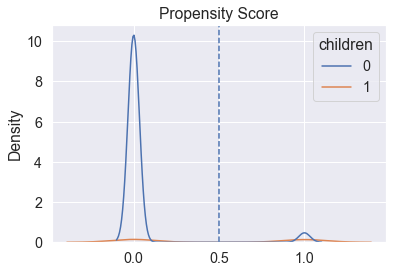

In [264]:
fig, ax = plt.subplots()
sns.kdeplot(x = predictions_up, hue = y_valid)
ax.axvline(0.5, ls='--')
ax.set_title('Propensity Score')
plt.show()